In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [11]:
df=pd.read_csv('../../Database/high_diamond_ranked_10min.csv',index_col=False)
scaler=StandardScaler()

In [12]:
y=df['blueWins']
X=scaler.fit_transform(df.drop(['blueWins'],axis=1))

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
import joblib

In [19]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=10):
    skf = KFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'balanced_accuracy'}    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    gs = GridSearchCV(model, scoring=scoring,cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='Accuracy')
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

In [20]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['rbf','linear']

param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
svm = SVC(class_weight='balanced')
gs,_,_=gridSearch(svm,param_grid,X,y,0.2)
joblib.dump(gs, 'experimentoSVM.pkl') #se guarda el gs para su posterior uso

SVC(C=10, class_weight='balanced', gamma=0.001, kernel='linear')
0.7317989468484043


['experimentoSVM.pkl']

In [21]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report


def experimentar(X,Y):

    #Validamos el modelo
    Folds = 10
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = SVC(class_weight='balanced',C=10,gamma=0.001,probability=True)
        model.fit(X=Xtrain, y=Ytrain)
        Yest = model.predict_proba(Xtest)
        
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1),normalize=True) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       494
           1       0.71      0.71      0.71       493

    accuracy                           0.71       987
   macro avg       0.71      0.71      0.71       987
weighted avg       0.71      0.71      0.71       987



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.809065,0.012573,0.728981,0.012404


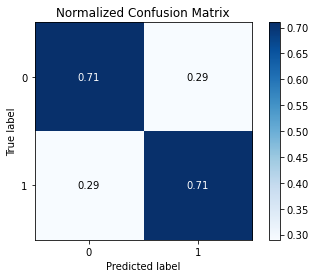

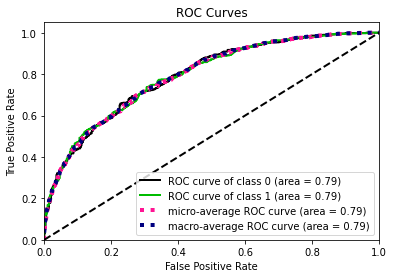

In [22]:
experimentar(X,y)